In [94]:
# ipykernel
# numpy
# graphviz
# matplotlib

In [95]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [96]:
def f(x):
    return 3*x**2 -4*x + 5

In [97]:
f(3.0)

20.0

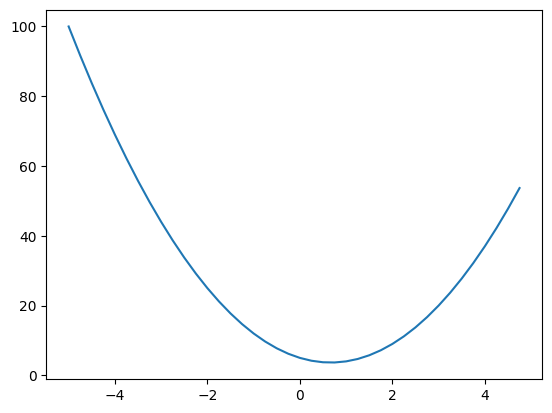

In [98]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [99]:
h = 0.0000001
x = 2/3

(f(x+h) - f(x) )/ h

2.9753977059954195e-07

In [100]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [101]:
h = 0.000001

a = 2.0
b = -3.0
c = 10.0


d1 = a * b + c

c += h

d2 = a * b + c

print("d1", d1)
print("d2", d2)

print("slope", (d2 - d1) / h )

d1 4.0
d2 4.000000999999999
slope 0.9999999992515995


In [102]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value( self.data ** other , (self, ), f'**{other}' )

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self, ), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return (-self) + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        return out

    def backward(self):

        self._backward()
        for v in self._prev:
            v.backward()

        return

        if self._prev:

            if self._op == '+':
                for v in self._prev:
                    v.grad = self.grad
            elif self._op == '*':
                child_1, child_2 = list(self._prev)
                print("child_1:", child_1)
                print("child_2:", child_2)

                child_1.grad = self.grad * child_2.data
                child_2.grad = self.grad * child_1.data

            for v in self._prev:
                v.backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')

L = d * f ; L.label = 'L'

L


Value(data=-8.0)

In [103]:

# b = Value(1)
# c = Value(2)
# e = Value(3)
# f = Value(4)

# # b = Value(1, ())
# # c = Value(2, ())
# # e = Value(3, ())
# # f = Value(4, ())

# a = b + c
# # a = Value(3, (&b, &c))

# d = e + f
# # d = Value(7, (&e, &f))

# z = a + d
# # z = Value(10, ((&a,&b), (&e,&f)) )


# print("b", b, b._prev, b._op)
# print("c", c, c._prev, c._op)
# print("e", e, e._prev, e._op)
# print("f", f, f._prev, f._op)
# print("a", a, a._prev, a._op)
# print("d", d, d._prev, d._op)
# print("z", z, z._prev, z._op)


# Visualize the Computational Graph

In [104]:
%pip install graphviz

In [105]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()

    def build(v):

        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label="{ %s |  data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record' )

        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


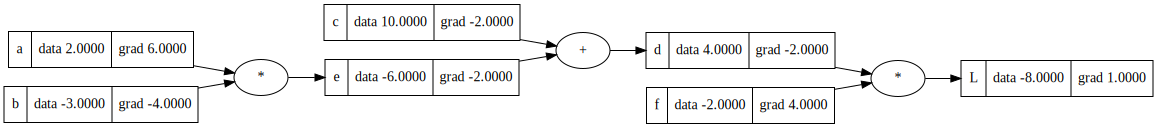

In [106]:
L.grad = 1
L.backward()
draw_dot(L)

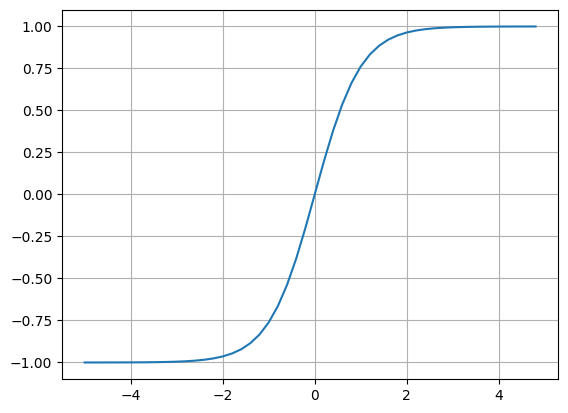

In [107]:
plt.plot(
    np.arange(-5, 5, 0.2),
    np.tanh(np.arange(-5, 5, 0.2))
) ;

plt.grid() ;

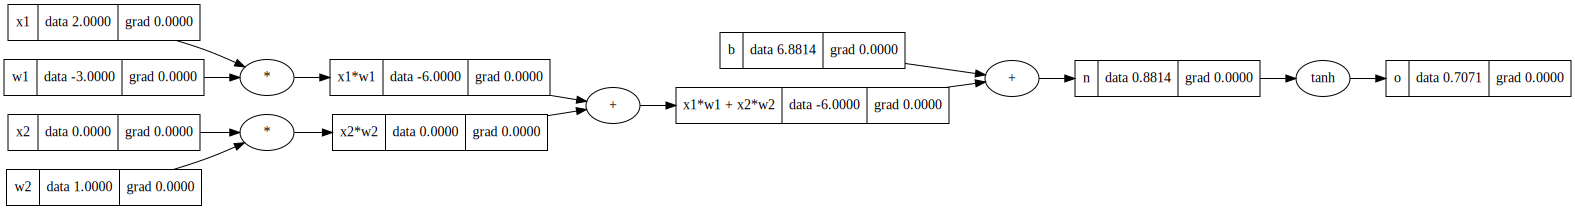

In [108]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)


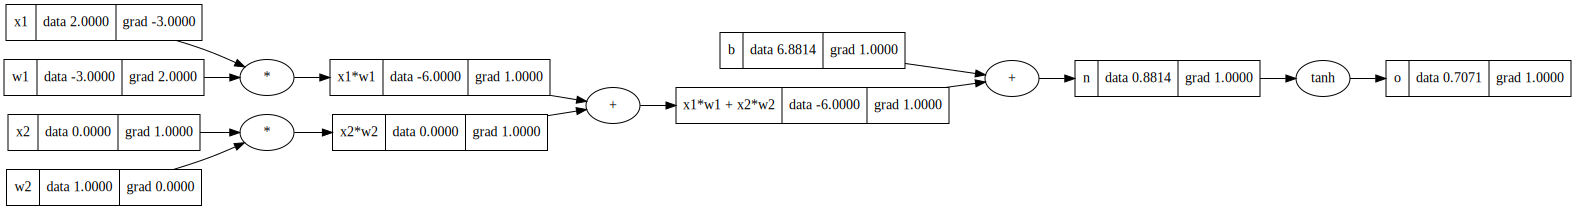

In [109]:
o.grad = 1.0
n.grad = 0.5
o.backward()
draw_dot(o)

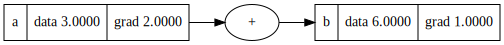

In [110]:
a = Value(3.0, label = 'a')
b = a + a ; b.label = 'b'
b.grad = 1
b.backward()
draw_dot(b)

In [111]:
b * 2


Value(data=12.0)

In [112]:
2 * b

Value(data=12.0)

In [113]:
b + 1

Value(data=7.0)

In [114]:
a = Value(2.0)
b = Value(4.0)

a / b

Value(data=0.5)

In [115]:
a - b

Value(data=-2.0)

# Using Torch

In [116]:
import torch

In [117]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())




0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [209]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))


    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [ p for neuron in self.neurons for p in neuron.parameters() ]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [ Layer(sz[i], sz[i+1]) for i in range(len(nouts)) ]


    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
# n = Layer(2, 3)
n = MLP(3, [4, 4, 1])

# mlp = MLP(2, [3, 2, 2, 1])

# v = mlp(x)
# draw_dot(v)
n(x)

Value(data=-0.13022474802528183)

In [194]:
a = Value(3.0)

a * 3.0

3.0 * a

Value(data=9.0)

In [195]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]


In [196]:
ypred = [n(x) for x in xs]

loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))



In [197]:
loss.grad = 1
loss.backward()

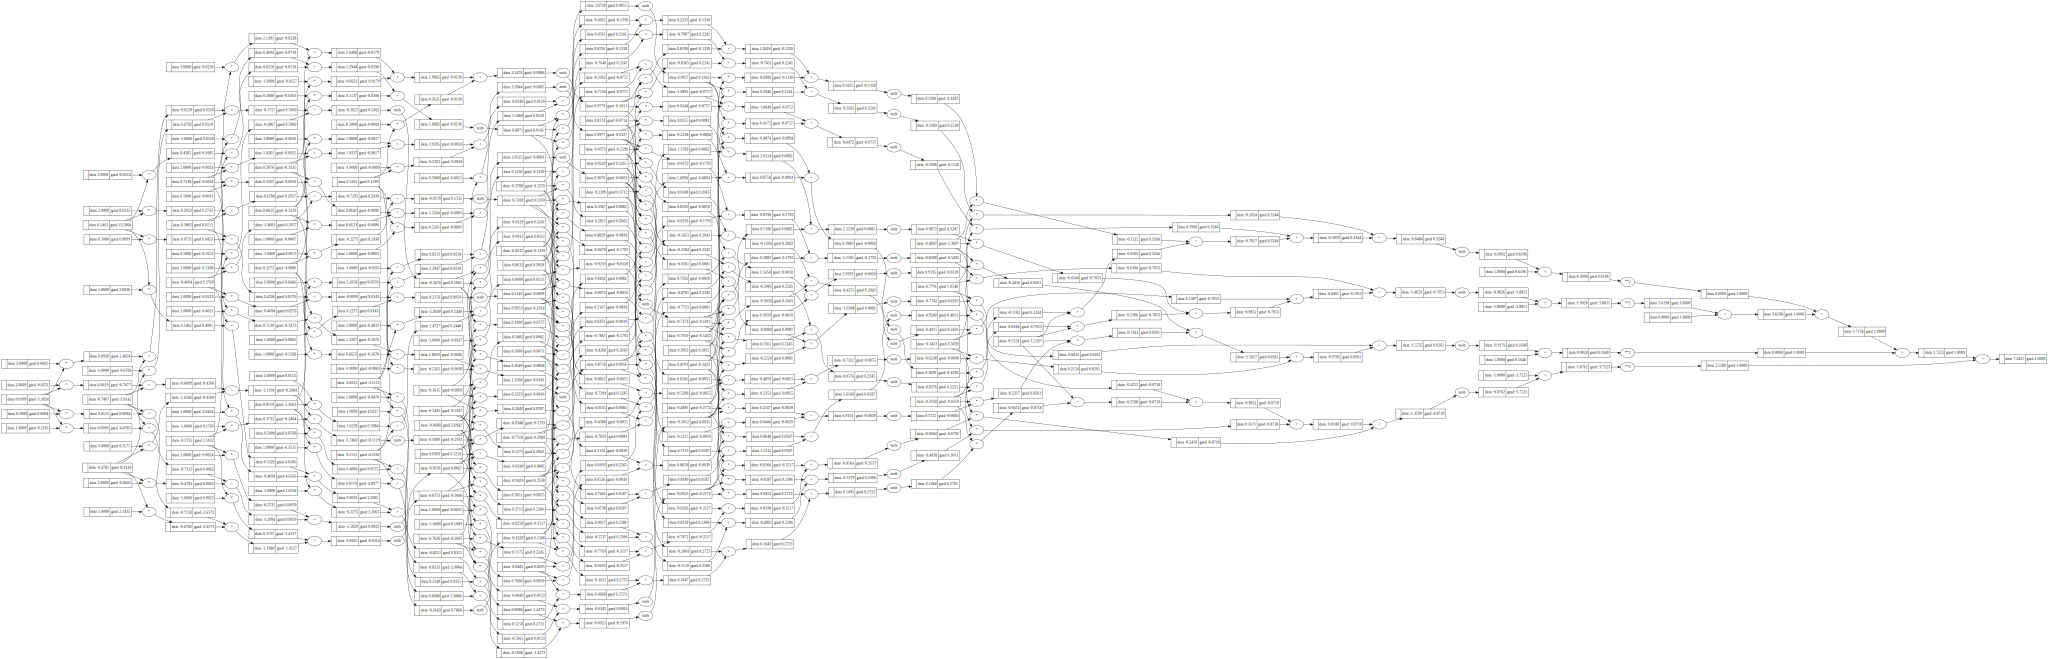

In [198]:
draw_dot(loss)

In [210]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]


In [211]:
# Training Loop

for k in range(5000):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip (ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0

    loss.grad = 1
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.001 * p.grad

    if k % 100 == 0:
        print(k, loss.data)


0 5.0146844251282925
100 0.6529849515246041
200 0.24508143970125093
300 0.1203906771153924
400 0.07623231152291929
500 0.05472304583104715
600 0.04241039466420929
700 0.034681595907918195
800 0.029234560547492613
900 0.025218123457746114
1000 0.02217055040668767
1100 0.01981156591436284
1200 0.017851632169896586
1300 0.016273851349397836
1400 0.01493370115827954
1500 0.013802808919306409
1600 0.012823227039373077
1700 0.011974357914226389
1800 0.011226664297684211
1900 0.01057648288840051
2000 0.00999914560425246
2100 0.009480082418770814
2200 0.009009805278947661
2300 0.008577676784590687
2400 0.008189863010030402
2500 0.00783652645867067
2600 0.007510690910785214
2700 0.007214690997813245
2800 0.006937838777349694
2900 0.0066844490578513525
3000 0.006445388607327062
3100 0.006224030651854642
3200 0.006016022245687992
3300 0.005823406643483455
3400 0.00564281895549265
3500 0.00547356158534573
3600 0.0053153100363851225
3700 0.005164806207905791
3800 0.005022788638957923
3900 0.0048871

In [212]:
ypred

[Value(data=0.9657618519084189),
 Value(data=-0.9831070377494131),
 Value(data=-0.9750774171502645),
 Value(data=0.9588249817010485)]

In [185]:



ypred

[Value(data=0.9990494211609466),
 Value(data=-0.9977386801933141),
 Value(data=-0.9975542824974281),
 Value(data=0.9990492590739646)]

In [130]:
n.layers[0].neurons[0].w[0].grad

13.371823624852901